In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff 

from mil import MILR
from mil import make_dataset_from_dataframe

import matplotlib.pyplot as plt

##### Dataset Information
From https://archive.ics.uci.edu/dataset/75/musk+version+2

This dataset describes a set of 102 molecules of which 39 are judged by human experts to be musks and the remaining 63 molecules are judged to be non-musks.  The goal is to learn to predict whether new molecules will be musks or non-musks.  However, the 166 features that describe these molecules depend upon the exact shape, or conformation, of the molecule.  Because bonds can rotate, a single molecule can adopt many different shapes.  To generate this data set, all the low-energy conformations of the molecules were generated to produce 6,598 conformations.  Then, a feature vector was extracted that describes each conformation. 

This many-to-one relationship between feature vectors and molecules is called the "multiple instance problem".  When learning a classifier for this data, the classifier should classify a molecule as "musk" if ANY of its conformations is classified as a musk.  A molecule should be classified as "non-musk" if NONE of its conformations is classified as a musk.


In [3]:
raw_data = loadarff('./data/musk1/musk.arff')
data = pd.DataFrame(raw_data[0])
data.rename(columns={'class': 'target'}, inplace=True)
data.target = data.target.astype(int)

display(data.head(5))
data[['molecule_name', 'target']].value_counts()


,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,...,f158,f159,f160,f161,f162,f163,f164,f165,f166,target
0,1.0,b'MUSK-211',b'211_1+1',46.0,-108.0,-60.0,-69.0,-117.0,49.0,38.0,...,-308.0,52.0,-7.0,39.0,126.0,156.0,-50.0,-112.0,96.0,1
1,2.0,b'MUSK-211',b'211_1+10',41.0,-188.0,-145.0,22.0,-117.0,-6.0,57.0,...,-59.0,-2.0,52.0,103.0,136.0,169.0,-61.0,-136.0,79.0,1
2,3.0,b'MUSK-211',b'211_1+11',46.0,-194.0,-145.0,28.0,-117.0,73.0,57.0,...,-134.0,-154.0,57.0,143.0,142.0,165.0,-67.0,-145.0,39.0,1
3,4.0,b'MUSK-211',b'211_1+12',41.0,-188.0,-145.0,22.0,-117.0,-7.0,57.0,...,-60.0,-4.0,52.0,104.0,136.0,168.0,-60.0,-135.0,80.0,1
4,5.0,b'MUSK-211',b'211_1+13',41.0,-188.0,-145.0,22.0,-117.0,-7.0,57.0,...,-60.0,-4.0,52.0,104.0,137.0,168.0,-60.0,-135.0,80.0,1


molecule_name     target
b'NON-MUSK-j146'  0         1044
b'NON-MUSK-252'   0         1010
b'NON-MUSK-j147'  0          911
b'NON-MUSK-f146'  0          383
b'NON-MUSK-288'   0          344
                            ... 
b'NON-MUSK-290'   0            2
b'MUSK-300'       1            2
b'MUSK-306'       1            2
b'NON-MUSK-j96'   0            1
b'NON-MUSK-j97'   0            1
Name: count, Length: 102, dtype: int64

In [4]:
feature_names = [f'f{i}' for i in range(1, 167)]
X, y, bags = make_dataset_from_dataframe(data, feature_names, 'target', 'molecule_name')

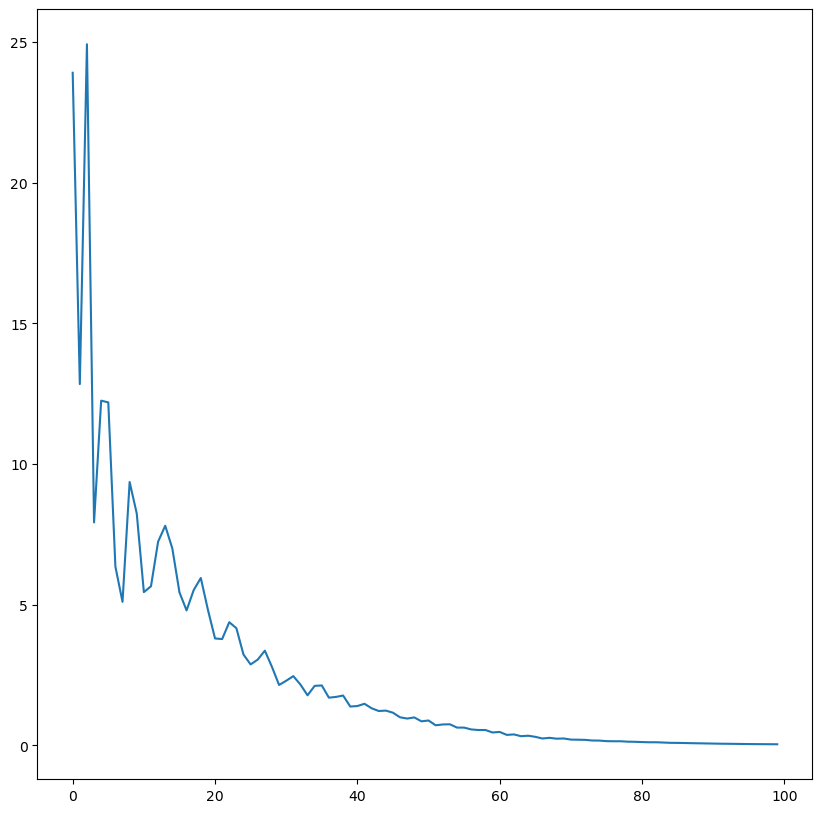

In [5]:
model = MILR()
model.fit(X, y, bags, epochs=100, lr=1e-2)

plt.figure(figsize=(10, 10))
plt.plot(model.losses)
